# Assignment report for CQF - Exam 3

$$ Amit\ Tembhurnikar $$
$$June,\ 2023 - Exam\ 3$$

<br>

# Follow the 7-steps to model building for your selected ticker using Random Forest Classifier

## Workflow

### 7 steps

| Steps| Workflow | Remarks|
|:---------|:-----------------|:-------------------|
|Step 1| Ideation | Predict positive up moves (Up trends) above 0.25% (transaction cost)|
|Step 2| Data collection | Download data from Yahoo Finance, store on local drive|
|Step 3| Exploration Data analysis | Study Summary statistics|
|Step 4| Cleaning Dataset | Check for any null values|
|Step 5| Transformation | Perform feature scaling based on EDA|
|Step 6| Modeling | Building and training Random Forest Classifier|
|Step 7| Metrics | Validating the model performance using score method|

#### Step 1: Ideation

Goal is to predict positive moves (up trends) above 0.05%, which currently considered to transaction cost for trading.

The asset in consideration is Nifty index, traded in India.

#### Step 2: Data collection

Data is taken from Yahoo finance for Nifty index, as Date, open, high, low, and close. We have downloaded the save directly from the website, for the maximum period available.

Other API providers like Marketstack and Alphavantage can also be used but historic data is limited.

#### Importing Libraries

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
# Data manipulation
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rcParams['figure.figsize'] = (20,10) # plt.style.use('fivethirtyeight')
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
                                    train_test_split,
                                    RandomizedSearchCV,
                                    TimeSeriesSplit,
                                    cross_val_score
                                    )

from sklearn.ensemble import RandomForestClassifier

# metrics
from sklearn.metrics import (precision_recall_curve,
                             roc_curve,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay
                            )
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             recall_score,
                             precision_score,
                             roc_auc_score,
                             auc
                            )

from sklearn.metrics import (classification_report,
                             confusion_matrix
)

# set display options
pd.options.display.float_format = "{:,.4f}".format
pd.set_option('display.max_columns', 100)

#### Load Data

In [3]:
# Load locally stored data
df = pd.read_excel('NIFTY PRICE.xlsx', index_col=0, parse_dates=True)
# Check first 5 values
df.head(5)

,Open,High,Low,Close
Date,,,,
2013-01-02,"5,982.6001","6,006.0498","5,982.0000","5,993.2500"
2013-01-03,"6,015.7998","6,017.0000","5,986.5498","6,009.5000"
2013-01-04,"6,011.9502","6,020.7500","5,981.5498","6,016.1499"
2013-01-07,"6,042.1499","6,042.1499","5,977.1499","5,988.3999"
2013-01-08,"5,983.4502","6,007.0498","5,964.3999","6,001.7002"


In [4]:
df.shape

(2664, 4)

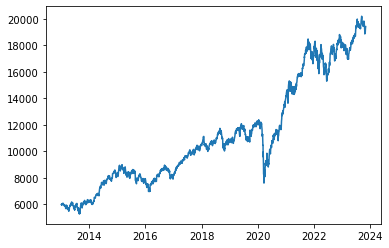

In [5]:
# Visualise the price trend
plt.plot(df['Close']);

#### Step 3: Exploration Data analysis of Original Dataset

In [6]:
# Descriptive statistics
df.describe()

,Open,High,Low,Close
count,"2,664.0000","2,664.0000","2,664.0000","2,664.0000"
mean,"11,241.4378","11,294.4971","11,168.7380","11,232.9304"
std,"4,047.9701","4,061.6788","4,026.5708","4,045.7334"
min,"5,233.4502","5,317.7002","5,118.8501","5,285.0000"
25%,"8,154.7499","8,196.3750","8,101.3873","8,151.2499"
50%,"10,423.2500","10,483.5249","10,358.9248","10,441.3501"
75%,"14,691.0625","14,752.6497","14,509.2622","14,639.5249"
max,"20,156.4492","20,222.4492","20,129.6992","20,192.3496"


#### Step 4: Cleaning Dataset

Check of any null values, and clean if any

In [7]:
# Check for null values
df.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

#### Step 5: Feature Engineering

#### Features List

| Features| Formula | Description|
|:---------------|:-----------------:|:-------------------|
|O-C, H-L| Open - Close, High - Low | intraday price range|
|Sign| $sign (rt = ln \frac{P_t}{P_{t-1}})$ | sign of return|
|Past Return| $r_{t-1}, r_{t-2}$ | lagged returns|
|Moving Average| $SMA_i = \frac{1}{n}\Sigma^{n-1}_{i=0} P_{t-i}$ | simple moving average|
|Momentum| $P_{t} - P_{t-k}$ | price change over k period|


In [8]:
# define create features
def create_features(frame):
    df = frame.copy()
    multiplier = 2
# features
    df['OC'] = df['Close'] - df['Open']
    df['HL'] = df['High'] - df['Low']
    df['RET'] = np.log(df['Close'] / df['Close'].shift(1))
    df["Return sign"] = np.where(df["RET"]>=0,1,0)
    for i in range(5, 100, 5):
        df['MOMENTUM' + str(i)] = df['Close'] - df['Close'].shift(i)
  
    for i in [7, 14, 28]:
        df['SMA' + str(i)] = df['Close'].rolling(i).mean()
    # drop NaN values
    df.drop(['Open', 'High', 'Low'], axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

##### Feature Specification

In [9]:
# create features
df1 = create_features(df)
display(df1.shape)

# verify the output
df1.head(2)

(2569, 27)

,Close,OC,HL,RET,Return sign,MOMENTUM5,MOMENTUM10,MOMENTUM15,MOMENTUM20,MOMENTUM25,MOMENTUM30,MOMENTUM35,MOMENTUM40,MOMENTUM45,MOMENTUM50,MOMENTUM55,MOMENTUM60,MOMENTUM65,MOMENTUM70,MOMENTUM75,MOMENTUM80,MOMENTUM85,MOMENTUM90,MOMENTUM95,SMA7,SMA14,SMA28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-05-22,"6,094.5000",-32.5498,73.1499,-0.0032,0,-52.2500,25.2002,164.2998,260.1001,565.9502,541.2500,411.9502,400.1001,243.2998,275.8999,297.6001,151.4502,161.5498,135.2998,38.7500,40.2002,92.6499,123.0000,101.2500,"6,123.5499","6,072.7214","5,918.6143"
2013-05-23,"5,967.0498",-83.3501,125.7500,-0.0211,0,-202.8501,-83.1001,-32.3003,130.1499,398.6499,424.0996,262.6499,308.2998,58.0996,103.7500,274.0000,114.7998,70.0996,28.2500,-67.7002,-52.3003,-72.1504,-1.6001,-42.4502,"6,119.4999","6,074.3678","5,933.1982"


In [10]:
# copy Close price to new dataframe and drop close price from existing dataframe
df2 = pd.DataFrame()
df2['Close'] = df1['Close'].copy()
df1.drop(['Close'], axis=1, inplace=True)
df2

,Close
Date,
2013-05-22,"6,094.5000"
2013-05-23,"5,967.0498"
2013-05-24,"5,983.5498"
2013-05-27,"6,083.1499"
2013-05-28,"6,111.2500"
...,...
2023-10-31,"19,079.5996"
2023-11-01,"18,989.1504"
2023-11-02,"19,133.2500"


In [11]:
df1

,OC,HL,RET,Return sign,MOMENTUM5,MOMENTUM10,MOMENTUM15,MOMENTUM20,MOMENTUM25,MOMENTUM30,MOMENTUM35,MOMENTUM40,MOMENTUM45,MOMENTUM50,MOMENTUM55,MOMENTUM60,MOMENTUM65,MOMENTUM70,MOMENTUM75,MOMENTUM80,MOMENTUM85,MOMENTUM90,MOMENTUM95,SMA7,SMA14,SMA28
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-05-22,-32.5498,73.1499,-0.0032,0,-52.2500,25.2002,164.2998,260.1001,565.9502,541.2500,411.9502,400.1001,243.2998,275.8999,297.6001,151.4502,161.5498,135.2998,38.7500,40.2002,92.6499,123.0000,101.2500,"6,123.5499","6,072.7214","5,918.6143"
2013-05-23,-83.3501,125.7500,-0.0211,0,-202.8501,-83.1001,-32.3003,130.1499,398.6499,424.0996,262.6499,308.2998,58.0996,103.7500,274.0000,114.7998,70.0996,28.2500,-67.7002,-52.3003,-72.1504,-1.6001,-42.4502,"6,119.4999","6,074.3678","5,933.1982"
2013-05-24,-27.1504,78.5000,0.0028,1,-203.7500,-111.2002,39.5498,67.2500,294.5996,488.4497,235.4497,332.1997,110.9497,37.8496,263.8496,133.2500,96.1499,80.0498,-15.3501,-91.1001,-80.8501,32.2500,-32.6001,"6,096.1856","6,075.2606","5,947.1107"
2013-05-27,93.7500,124.3501,0.0165,1,-73.7500,102.6997,112.1001,211.6997,394.4497,524.4497,410.2500,449.2998,247.8999,140.7998,384.6499,228.3999,184.9497,185.2998,95.8999,8.3501,0.8501,59.1001,94.7500,"6,083.7928","6,078.0892","5,966.9178"
2013-05-28,24.8999,72.2500,0.0046,1,-2.8501,115.8501,67.7002,207.1499,328.1499,517.2500,536.5000,469.6499,365.2998,197.1499,327.0000,349.8999,171.5498,188.7500,154.3501,61.3501,62.7500,54.6499,109.5498,"6,072.9285","6,081.0857","5,986.3053"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31,-153.3496,177.2500,-0.0032,0,-202.1504,-652.1504,-432.7500,-558.7012,-594.6504,"-1,023.5000",-647.4512,-174.2012,-307.0996,-285.6504,-552.9512,-446.9512,-698.7012,-753.5508,-304.7012,-318.9004,262.1992,262.9004,363.4492,"19,153.0787","19,447.6429","19,541.7446"
2023-11-01,-74.9004,122.3516,-0.0048,0,-133.0000,-822.3496,-700.6992,-539.5996,-685.4004,"-1,203.1992",-830.7988,-446.1504,-276.6504,-321.0000,-553.9492,-392.5000,-670.7500,-990.0000,-424.5996,-508.1504,17.0508,132.3008,233.2500,"19,074.0073","19,388.9143","19,509.1643"
2023-11-02,13.2500,111.0996,0.0076,1,276.0000,-537.8496,-678.0996,-302.8496,-531.4492,"-1,000.0508",-863.0996,-395.5508,-172.8008,-260.3496,-295.0508,-383.7500,-512.8008,-611.7500,-431.2500,-198.5508,-55.8008,362.0000,445.1504,"19,052.7930","19,341.7179","19,487.4107"


##### Feature Selection

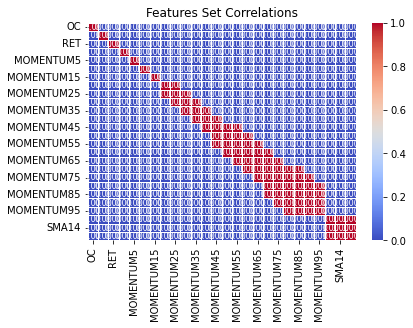

In [12]:
# remove features that are highly correlated
sns.heatmap(df1.corr()>0.9,
            annot=True,
annot_kws={"size": 8},
fmt=".2f",
linewidth=.5,
cmap="coolwarm",
cbar=True); #cmap="crest", virids, magma
plt.title('Features Set Correlations');

In [13]:
# remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = df1.corr()
    for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    colname = corr_matrix.columns[i]
                    col_corr.add(colname)
    return col_corr

In [14]:
# total correlated features
drop_correlated_features = correlated_features(df1) # drop the highly correlated features
X = df1.drop(drop_correlated_features, axis=1)
# record feature names
feature_names = X.columns

In [15]:
# display the new features set
X

,OC,HL,RET,Return sign,MOMENTUM5,MOMENTUM10,MOMENTUM15,MOMENTUM20,SMA7
Date,,,,,,,,,
2013-05-22,-32.5498,73.1499,-0.0032,0,-52.2500,25.2002,164.2998,260.1001,"6,123.5499"
2013-05-23,-83.3501,125.7500,-0.0211,0,-202.8501,-83.1001,-32.3003,130.1499,"6,119.4999"
2013-05-24,-27.1504,78.5000,0.0028,1,-203.7500,-111.2002,39.5498,67.2500,"6,096.1856"
2013-05-27,93.7500,124.3501,0.0165,1,-73.7500,102.6997,112.1001,211.6997,"6,083.7928"
2013-05-28,24.8999,72.2500,0.0046,1,-2.8501,115.8501,67.7002,207.1499,"6,072.9285"
...,...,...,...,...,...,...,...,...,...
2023-10-31,-153.3496,177.2500,-0.0032,0,-202.1504,-652.1504,-432.7500,-558.7012,"19,153.0787"
2023-11-01,-74.9004,122.3516,-0.0048,0,-133.0000,-822.3496,-700.6992,-539.5996,"19,074.0073"
2023-11-02,13.2500,111.0996,0.0076,1,276.0000,-537.8496,-678.0996,-302.8496,"19,052.7930"


##### EDA for Feature Scaling

In [16]:
# decide which scaling to use
X.describe()

,OC,HL,RET,Return sign,MOMENTUM5,MOMENTUM10,MOMENTUM15,MOMENTUM20,SMA7
count,"2,569.0000","2,569.0000","2,569.0000","2,569.0000","2,569.0000","2,569.0000","2,569.0000","2,569.0000","2,569.0000"
mean,-8.7336,128.0101,0.0004,0.5387,25.3287,50.7313,77.3928,104.3276,"11,415.3724"
std,95.7923,89.2917,0.0107,0.4986,267.6232,386.7513,475.5886,551.2378,"3,977.5899"
min,-619.6504,24.9004,-0.1390,0.0000,"-1,989.6006","-3,379.2002","-3,591.5000","-4,470.5996","5,376.1643"
25%,-53.2500,72.7500,-0.0045,0.0000,-112.3496,-135.4004,-142.9492,-156.8501,"8,259.3502"
50%,-5.4004,103.2998,0.0007,1.0000,40.7998,73.4502,101.8008,130.1499,"10,561.6642"
75%,42.5000,157.8008,0.0062,1.0000,171.3501,253.6504,338.9502,415.2998,"14,810.3785"
max,847.6006,"1,604.2500",0.0840,1.0000,"1,289.6504","1,528.7002","1,656.5000","2,094.2500","20,055.6713"


Moving avearages have high correlation, thus dropped.

The 0.07% daily median return helps to under the possible threshold for our target definition. The median return finding will help in the class imbalance. Example if positive are above median return, weights of positive decreases as we above the median and vice versa

#### Target or Label Definition

Label or the target variable is also known as the dependent variable. Here, the target variable is whether Nifty Index price will close up or down on the next trading day. If the tomorrow’s closing price is greater than the 0.05% of today’s closing price, then we will buy the Nifty, else we will sell the index.

We assign a value of +1 for the buy signal and 0 for the sell signal to target variable. The target can be described as :

$$
y_t = \left\{ \begin{array}{ll}
         +1 & \mbox{if $p_{t+1} \geq 1.0005*p_t$};\\
         0 & \mbox{if $p_{t+1}Otherwise $}.\end{array} \right.
$$

where, $p_t$ is the current closing price of Nifty Index and $p_{t+1}$ is the 1-day forward closing price of the index.

In [17]:
y = np.where(df2['Close'].shift(-1)>=1.0005 * df2['Close'],1,0)
y

array([0, 1, 1, ..., 1, 1, 0])

In [18]:
# Value counts for class 1 and 0
pd.Series(y).value_counts()

1    1308
0    1261
dtype: int64

As mentioned above, the threshold below median helps to have higher weigth in positive class. However, we are also trying to minimize the impact of transaction cost, thus considering the transaction cost as 0.05%.   

**Split Data**

In [19]:
# Value counts for class 1 and -1
pd.Series(y).value_counts()
# Splitting the datasets into training and testing data.
# Always keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [20]:
# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 2055, 514


#### Step 6: Modeling: Building and training Random Forest Classifier

#### Base Model

Fit Model

In [21]:
# Scale and fit the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Predict Model

In [22]:
# Predicting the test dataset
y_pred = model.predict(X_test)
# Predict Probabilities
y_proba = model.predict_proba(X_test)

In [23]:
# verify the class labels
model.classes_

array([0, 1])

In [24]:
# predict probability
y_proba[-20:]

array([[0.65, 0.35],
       [0.36, 0.64],
       [0.5 , 0.5 ],
       [0.52, 0.48],
       [0.61, 0.39],
       [0.69, 0.31],
       [0.75, 0.25],
       [0.61, 0.39],
       [0.49, 0.51],
       [0.58, 0.42],
       [0.41, 0.59],
       [0.39, 0.61],
       [0.49, 0.51],
       [0.59, 0.41],
       [0.63, 0.37],
       [0.42, 0.58],
       [0.44, 0.56],
       [0.56, 0.44],
       [0.48, 0.52],
       [0.49, 0.51]])

In [25]:
# predict class labels
y_pred[-20:]

array([0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1])

In [26]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 1.0, Test Accuracy: 0.5175


The test accuracy is very less, suggesting that the model is overfitting.

#### Step 7: Validate the model performance using score method

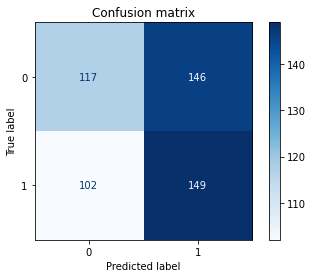

In [27]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        model,
X_test,
y_test,
display_labels=model.classes_, cmap=plt.cm.Blues
    )
plt.title('Confusion matrix')
plt.show()

In [28]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.44      0.49       263
           1       0.51      0.59      0.55       251

    accuracy                           0.52       514
   macro avg       0.52      0.52      0.52       514
weighted avg       0.52      0.52      0.51       514



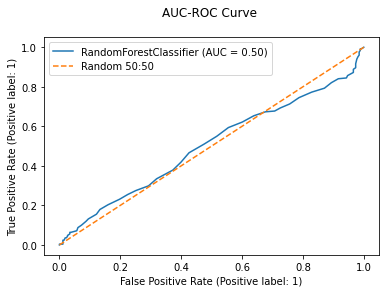

In [29]:
# Display ROCCurve
disp = RocCurveDisplay.from_estimator(
            model,
            X_test,
            y_test,
            name='RandomForestClassifier')
plt.title("AUC-ROC Curve \n")
plt.plot([0,1],[0,1],linestyle="--", label='Random 50:50')
plt.legend()
plt.show()

The model has test accuracy of 52% and recall for Class 1 is 59%

#### Hyper-parameter tuning

We are passed as arguments to the constructor of the estimator classes (Classifier in this case) and will search the hyper-parameter space for the best cross validation score. 

We will tune the hyperparameters to select the best score by TimeSeriesSplit cross-validation. 

In [30]:
tscv = TimeSeriesSplit(n_splits=5, gap=1)

For Hyper parameter tuning we are using RandomizedSearchCV.

The RandomizedSearchCV implements a “fit” and a “score” method and perform randomized search
on hyper parameters. The parameters of the estimator used to apply these methods are optimized
by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter
values are tried out, but rather a fixed number of parameter settings is sampled from the specified
distributions

In [31]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [32]:
# Number of trees in random forest
n_estimators = [x for x in range(5,150,5)]
# Number of features to consider at every split
max_features = ['sqrt','log']
# Maximum number of levels in tree
max_depth = [2,3,4,5,6]
# Minimum number of samples required to split a node
min_samples_split = [2,3,4,5,6]
# Maximum number of leaf nodes
max_terminal_nodes = [1,2,3]
max_samples = [0.5,0.75,1.0]
#Minimum number of samples required at each leaf node
min_samples_leaf = [20,30,40,50,100]
# Method of selecting samples for training each tree
bootstrap = [True, False]
class_weight = [
    {0:0.15,1:0.85},
    {0:0.2,1:0.8},
    {0:0.25,1:0.75},
    {0:0.3,1:0.7},    
]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'max_leaf_nodes': max_terminal_nodes,
               'max_samples' : max_samples,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap': bootstrap}
               
print(param_grid)

{'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145], 'max_features': ['sqrt', 'log'], 'max_depth': [2, 3, 4, 5, 6], 'min_samples_split': [2, 3, 4, 5, 6], 'max_leaf_nodes': [1, 2, 3], 'max_samples': [0.5, 0.75, 1.0], 'min_samples_leaf': [20, 30, 40, 50, 100], 'bootstrap': [True, False]}


In [33]:
# perform random search
rs = RandomizedSearchCV(model, param_grid, n_iter=100, scoring='f1', cv=tscv, verbose=0)

rs.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5, 6],
                                        'max_features': ['sqrt', 'log'],
                                        'max_leaf_nodes': [1, 2, 3],
                                        'max_samples': [0.5, 0.75, 1.0],
                                        'min_samples_leaf': [20, 30, 40, 50,
                                                             100],
                                        'min_samples_split': [2, 3, 4, 5, 6],
                                        'n_estimators': [5, 10, 15, 20, 25, 30,
                                                         35, 40, 45, 50, 55, 60,
                                                         65, 70, 75, 80, 85, 90,
                     

In [34]:
# best parameters
rs.best_params_

{'n_estimators': 5,
 'min_samples_split': 4,
 'min_samples_leaf': 20,
 'max_samples': 1.0,
 'max_leaf_nodes': 3,
 'max_features': 'sqrt',
 'max_depth': 3,
 'bootstrap': True}

In [35]:
# best score
rs.best_score_

0.5259890817145669

#### Predict and Validate the performance of tuned model using score method

In [36]:
# Refit the RFC with the best params
cls = RandomForestClassifier(**rs.best_params_)
cls.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features='sqrt', max_leaf_nodes=3,
                       max_samples=1.0, min_samples_leaf=20,
                       min_samples_split=4, n_estimators=5)

In [37]:
# Cross validation score
score = cross_val_score(cls,X_train,y_train,cv=tscv)
print(f'Mean CV Score : {score.mean():0.4}')


Mean CV Score : 0.5053


In [38]:
# Predicting the test dataset
y_pred = cls.predict(X_test)
# Measure Accuracy
acc_train = accuracy_score(y_train, cls.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
# Print Accuracy
print(f'\n Training Accuracy \t:{acc_train :0.4} \n Test Accuracy \t\t:{acc_test :0.4}')



 Training Accuracy 	:0.5635 
 Test Accuracy 		:0.537


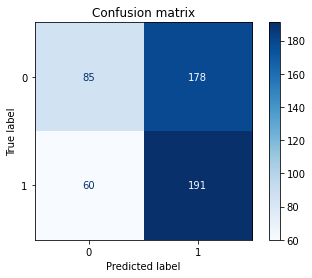

In [39]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
cls,
X_test,
y_test,
display_labels=model.classes_,
cmap=plt.cm.Blues
)
disp.ax_.set_title('Confusion matrix')
plt.show()


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.32      0.42       263
           1       0.52      0.76      0.62       251

    accuracy                           0.54       514
   macro avg       0.55      0.54      0.52       514
weighted avg       0.55      0.54      0.51       514



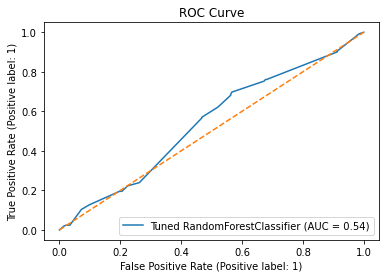

In [41]:
# Display ROCCurve
disp_roc = RocCurveDisplay.from_estimator(
cls,
X_test,
y_test,
name='Tuned RandomForestClassifier')
disp_roc.ax_.set_title('ROC Curve')
plt.plot([0,1], [0,1], linestyle='--')
plt.show()


#### Observation

1. Test accuracy improved by 2% as compared to the earlier model, also we can see the overfitting is decreased significantly.
2. Recall for Class +1 improved by more than 17% as compared to the earlier model while recall for Class 0 decreased by 12%.
3. Model improved predictor for upside, as we can see the increase in true positive when compared to the downside.
4. Class imbalance skews the prediction and needs to be addressed.

## Trading Strategy

Let’s now define a trading strategy. We will use the predicted signal to buy or sell. We then compare the result of this strategy with the buy and hold and visualize the performance of the RandomForestClassifier Algorithm.

We will test the return for last 3 year, starting 6th Nov'23.

In [42]:
# Subsume into a new dataframe
df2['Signal'] = cls.predict(X) # clf.predict(X_test)

In [43]:
# Daily Returns - Benchmark return
df2['Returns'] = np.log(df2['Close']).diff().fillna(0)
# Strategy Returns - RFC
df2['Strategy'] = df2['Returns'] * df2['Signal'].shift(1).fillna(0)
# Localize index for pyfolio
df2.index = df2.index.tz_localize('utc')

In [44]:
 # Check the output
df2.tail(10)

,Close,Signal,Returns,Strategy
Date,,,,
2023-10-23 00:00:00+00:00,"19,281.7500",1,-0.0134,-0.0000
2023-10-25 00:00:00+00:00,"19,122.1504",1,-0.0083,-0.0083
2023-10-26 00:00:00+00:00,"18,857.2500",0,-0.0139,-0.0139
2023-10-27 00:00:00+00:00,"19,047.2500",1,0.0100,0.0000
2023-10-30 00:00:00+00:00,"19,140.9004",1,0.0049,0.0049
2023-10-31 00:00:00+00:00,"19,079.5996",0,-0.0032,-0.0032
2023-11-01 00:00:00+00:00,"18,989.1504",0,-0.0048,-0.0000
2023-11-02 00:00:00+00:00,"19,133.2500",1,0.0076,0.0000
2023-11-03 00:00:00+00:00,"19,230.5996",1,0.0051,0.0051


In [45]:
# Import pyfolio
import pyfolio as pf

Start date,2013-05-22
End date,2023-11-06
Total months,122
,Backtest
Annual return,18.219%
Cumulative returns,450.825%
Annual volatility,14.209%
Sharpe ratio,1.25
Calmar ratio,0.58
Stability,0.98
Max drawdown,-31.187%


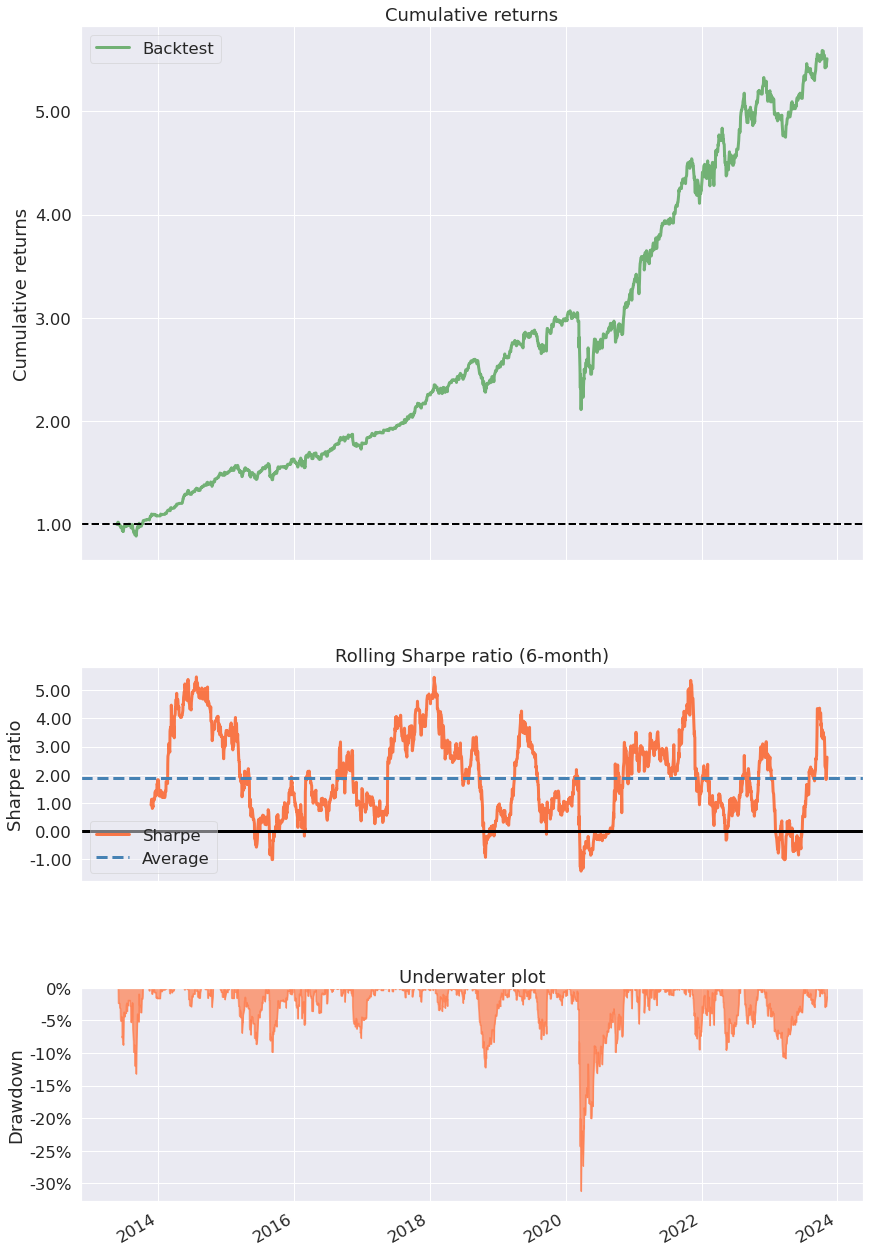

In [46]:
# Create Tear sheet using pyfolio for outsample - for X_test
pf.create_simple_tear_sheet(df2['Strategy'])

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,31.19,2020-01-24,2020-03-23,2020-11-10,208
1,13.20,2013-05-28,2013-09-03,2013-10-10,98
2,12.24,2018-08-31,2018-10-25,2019-02-01,111
3,10.85,2022-12-01,2023-03-28,2023-07-06,156
4,9.87,2015-08-14,2015-09-04,2015-12-10,85


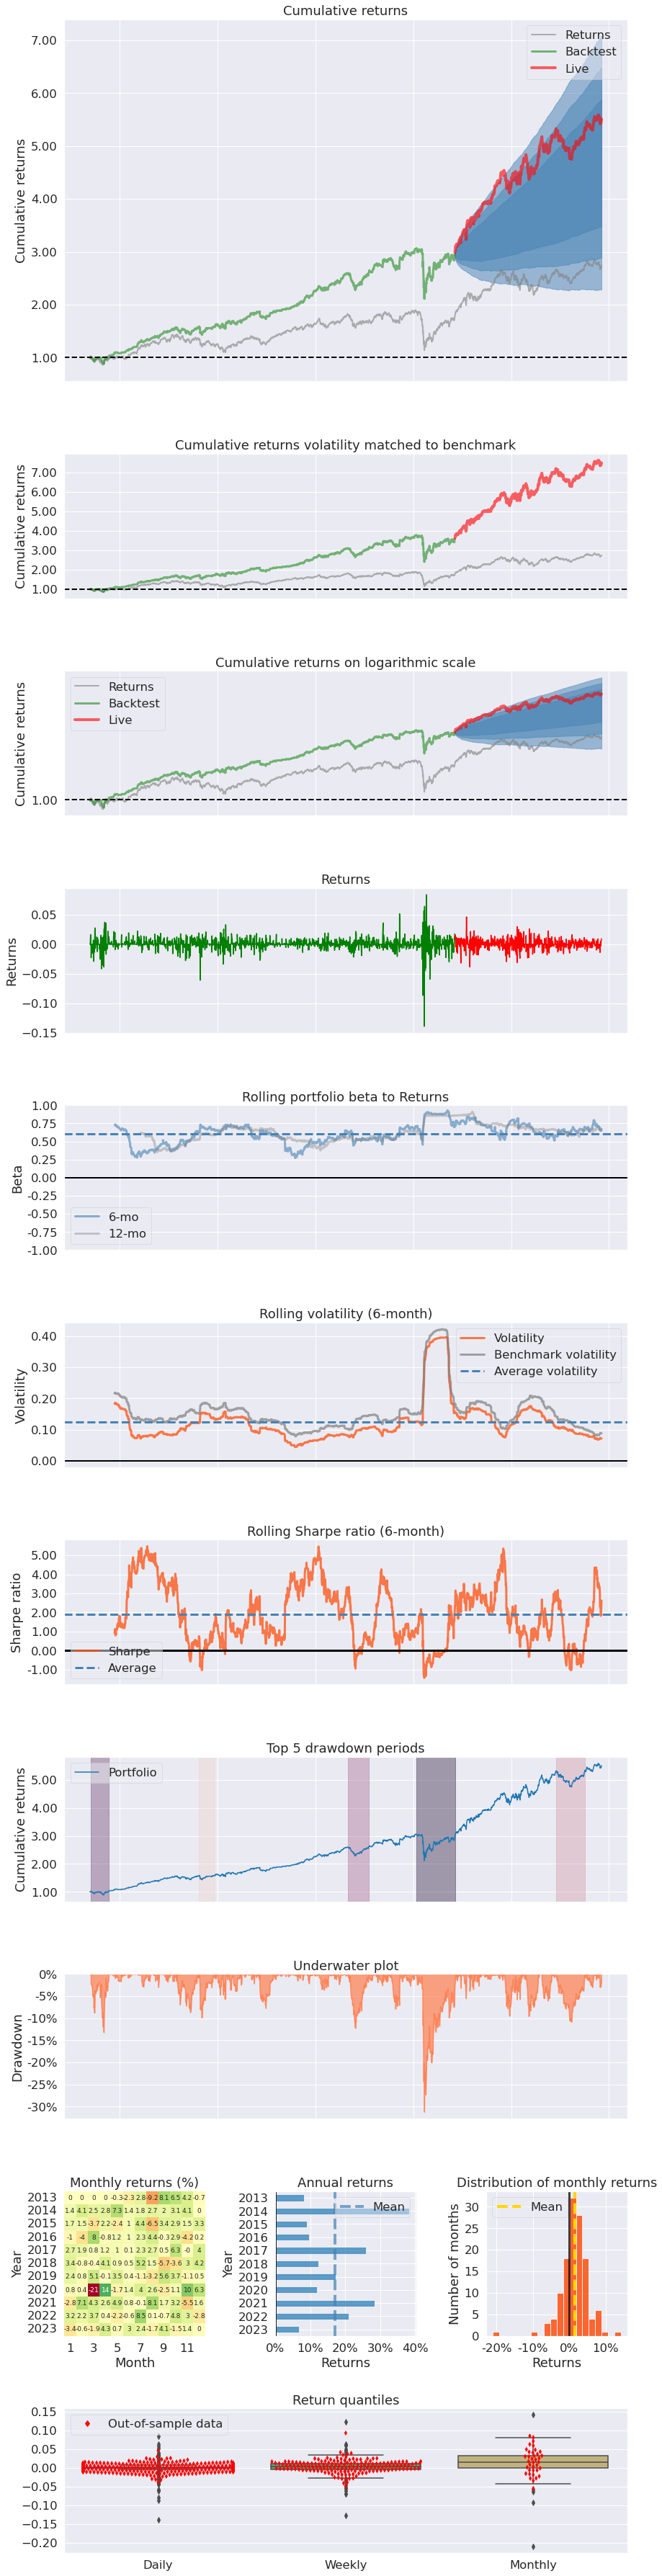

In [49]:
# Live start date 2020-11-06
pf.create_returns_tear_sheet(df2['Strategy'], live_start_date='2020-11-06',benchmark_rets=df2['Returns'])

**Observation:**<br>
The CAGR return for the out sample is 23.6%, on the higher side compare to the in-sample.<br>
The absolute monthly return by this strategy is negative just for 1 month, while has also a positive return for absolute annual returns.<br>
The distribution of monthly return from is strategy is left skewed.

**Reference**

Kannan Singaravelu, CQF June-2023 - Supervised Learning I (M4L4), and Supervised Learning II (M4L5)<br>
Kannan.Singaravelu, Python Labs - 09 Introduction to Machine Learning using Scikit-learn<br>
Kannan.Singaravelu, Python Labs - 10 KNN & SVR for Stock Prediction<br>
Kannan.Singaravelu, Python Labs - 11 Gradient Boosting for Price Prediction.

<br>